# Imports

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl


%reload_ext autoreload
%autoreload 2
from src.data_utils import unzip, load_data
from src.preprocess import merge, preprocess_ratings, preprocess_movies, preprocess_users
from benchmark.evaluate import test_recall

# Prepare data

In [24]:
def get_train_test(base='u1'):
    users, items, ratings_train = load_data(f'{base}.base')
    users, items, ratings_test = load_data(f'{base}.test')

    users, items = preprocess_users(users), preprocess_movies(items)
    ratings_train, ratings_test = preprocess_ratings(ratings_train), preprocess_ratings(ratings_test)

    data_train = merge(ratings_train, users, items)
    data_test = merge(ratings_test, users, items)

    return data_train, data_test

unzip()

bases = ['u1','u2','u3','u4','u5', 'ua', 'ub']
data = []

for base in bases:
    data.append(get_train_test(base))

Successfully extracted to data/interim/


### Print number of users and movies used in each part of data u1..u5 base and test

In [25]:
print('Base|Train Movies|Test Movie|Train users|Test users')
for base, (train, test) in zip(bases,data):
    print(base, train['movie_id'].nunique(),test['movie_id'].nunique(), train['user_id'].nunique(),test['user_id'].nunique())

Base|Train Movies|Test Movie|Train users|Test users
u1 1650 1410 943 459
u2 1648 1420 943 653
u3 1650 1423 943 869
u4 1660 1394 943 923
u5 1650 1407 943 927
ua 1680 1129 943 943
ub 1675 1145 943 943


 # Training and testing
 Calculate RMSE and MAE

In [26]:
maes, rmses = [], []
models = {}
for base, (data_train, test_data) in zip(bases, data):
    # Split train and test
    train, test = data_train.drop(columns=['user_id', 'movie_id']), test_data.drop(columns=['user_id', 'movie_id'])

    # Split X and y
    X_train = train.drop('rating', axis=1)
    X_test = test.drop('rating', axis=1)
    y_train = train['rating']
    y_test = test['rating']

    # Rescale from 1 to 5
    y_train = y_train*4+1
    y_test = y_test*4+1

    # Train model
    model = RandomForestRegressor(random_state=123)
    model.fit(X_train, y_train)
    models[base]=model

    # Save model
    pkl.dump(model, open(f'models/{base}.pkl', 'wb'))

    predictions = pkl.load(open(f'models/{base}.pkl', 'rb')).predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, predictions)
    rmse = mean_squared_error(y_true=y_test, y_pred=predictions)**0.5

    print(f'Base: {base}, RMSE: {rmse:.4f}. MAE: {mae:.4f}')  

    maes.append(mae)
    rmses.append(rmse)

print(f'Avg MAE: {np.mean(maes)}. Avg RMSE: {np.mean(rmses)}')

Base: u1, RMSE: 1.0205. MAE: 0.8156
Base: u2, RMSE: 1.0060. MAE: 0.8011
Base: u3, RMSE: 0.9963. MAE: 0.7930
Base: u4, RMSE: 1.0041. MAE: 0.7999
Base: u5, RMSE: 1.0066. MAE: 0.8023
Base: ua, RMSE: 1.0311. MAE: 0.8252
Base: ub, RMSE: 1.0429. MAE: 0.8316
Avg MAE: 0.8097977482102579. Avg RMSE: 1.015340711553398


# Check recall

### Check how many ratings each user gave in the different test sets
Measure mean, median and min to understand what is more less suitable K

In [29]:
for base in bases:
    um = load_data(f'{base}.test')[2][['user_id', "movie_id"]]
    l = list(um.groupby(by=['user_id']))

    sizes = []
    for i in l:
        sizes.append(i[1].shape[0])

    mi, me, min = np.mean(sizes), np.median(sizes), np.min(sizes)
    print(f'Base: {base}, Mean: {mi:f}, Med: {me}, Min: {min}')

Base: u1, Mean: 43.572985, Med: 25.0, Min: 1
Base: u2, Mean: 30.627871, Med: 18.0, Min: 1
Base: u3, Mean: 23.014960, Med: 13.0, Min: 1
Base: u4, Mean: 21.668472, Med: 12.0, Min: 1
Base: u5, Mean: 21.574973, Med: 11.0, Min: 1
Base: ua, Mean: 10.000000, Med: 10.0, Min: 10
Base: ub, Mean: 10.000000, Med: 10.0, Min: 10


# Benchmark

## Calculate recall for different test sets

In [30]:
k = 10 # how many movies to recommend to each user - the higher the better recall
liked_rating = 4 # only movies with rating >= 4 are considered as liked by user

total_recall = [] # recall for each dataset part
for base in ['u1','u2','u3','u4','u5']: 
    recalls = test_recall(base, k=k, liked_rating=liked_rating, model=models[base])
    mean = np.mean(recalls)
    print(f'Base: {base}. Avg recall: {mean:4f}')
    total_recall.append(mean)

print(f'Mean recall on different dataset parts: {np.mean(total_recall):.4f}')
    

Base: u1. Avg recall: 0.535577
Base: u2. Avg recall: 0.636331
Base: u3. Avg recall: 0.715343
Base: u4. Avg recall: 0.742827
Base: u5. Avg recall: 0.757044
Mean recall on different dataset parts: 0.6774


# Vizualize results

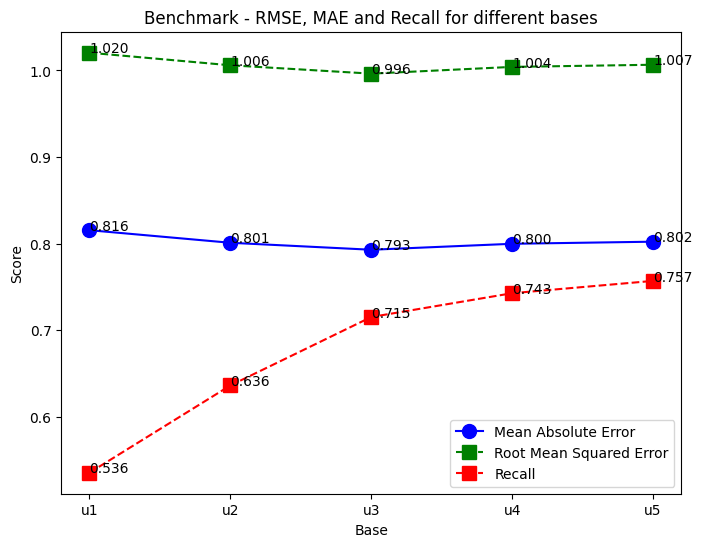

In [40]:
xs = [1, 2, 3, 4, 5]
labels = ['u1', 'u2', 'u3', 'u4', 'u5']
maes, rmses = maes[:5], rmses[:5]

plt.figure(figsize=(8, 6))
plt.plot(xs, maes, marker='o', linestyle='-', color='blue', markersize=10, label='Mean Absolute Error')
plt.plot(xs, rmses, marker='s', linestyle='--', color='green', markersize=10, label='Root Mean Squared Error')
plt.plot(xs, total_recall, marker='s', linestyle='--', color='red', markersize=10, label='Recall')

# Annotate each point for the first line
for x, y, label in zip(xs, maes, labels):
    plt.text(x, y, f'{y:.3f}', fontsize=10, color='black')

# Annotate each point for the second line
for x, y, label in zip(xs, rmses, labels):
    plt.text(x, y, f'{y:.3f}', fontsize=10, color='black')

# Annotate each point for the third line
for x, y, label in zip(xs, total_recall, labels):
    plt.text(x, y, f'{y:.3f}', fontsize=10, color='black')

# Set x-axis labels to 'A', 'B', 'C', 'D', 'E'
plt.xticks(xs, labels)

# Set plot labels, title, and legend
plt.title('Benchmark - RMSE, MAE and Recall for different bases')
plt.xlabel('Base')
plt.ylabel('Score')
plt.legend()

# Save plot
plt.savefig('benchmark.png')

plt.show()